Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [97]:
from random import random, seed
from itertools import accumulate
from itertools import product
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [98]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
DENSITY = 0.2

MAX_STEPS = 10000
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(NUM_SETS * DENSITY)]))

In [99]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [100]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def tweak(solution):
    new_solution = solution.copy()
    
    #tweak
    for n in range(int(100*DENSITY)):
        new_solution[np.random.randint(NUM_SETS)] = not new_solution[np.random.randint(NUM_SETS)]
    
    return new_solution

## Have Fun!

In [101]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4274436.523750271))

In [102]:
# A random solution with random 50% of the sets
#solution = rng.random(NUM_SETS) < .5
#valid(solution), cost(solution)

In [103]:
#rng.

ic| steps: 1


    cost(current_solution): np.float64(4274436.523750271)
    cost(new_solution): np.float64(4189535.970395444)
ic| steps: 2
    cost(current_solution): np.float64(4189535.970395444)
    cost(new_solution): np.float64(4107401.313058397)
ic| steps: 3
    cost(current_solution): np.float64(4107401.313058397)
    cost(new_solution): np.float64(4026097.8301755036)
ic| steps: 4
    cost(current_solution): np.float64(4026097.8301755036)
    cost(new_solution): np.float64(3962767.7790901344)
ic| steps: 5
    cost(current_solution): np.float64(3962767.7790901344)
    cost(new_solution): np.float64(3898619.6773678944)
ic| steps: 6
    cost(current_solution): np.float64(3898619.6773678944)
    cost(new_solution): np.float64(3826443.5270843282)
ic| steps: 7
    cost(current_solution): np.float64(3826443.5270843282)
    cost(new_solution): np.float64(3770916.8448290937)
ic| steps: 8
    cost(current_solution): np.float64(3770916.8448290937)
    cost(new_solution): np.float64(3706754.6747500263)
i

(np.True_, np.float64(1245685.1524509138))

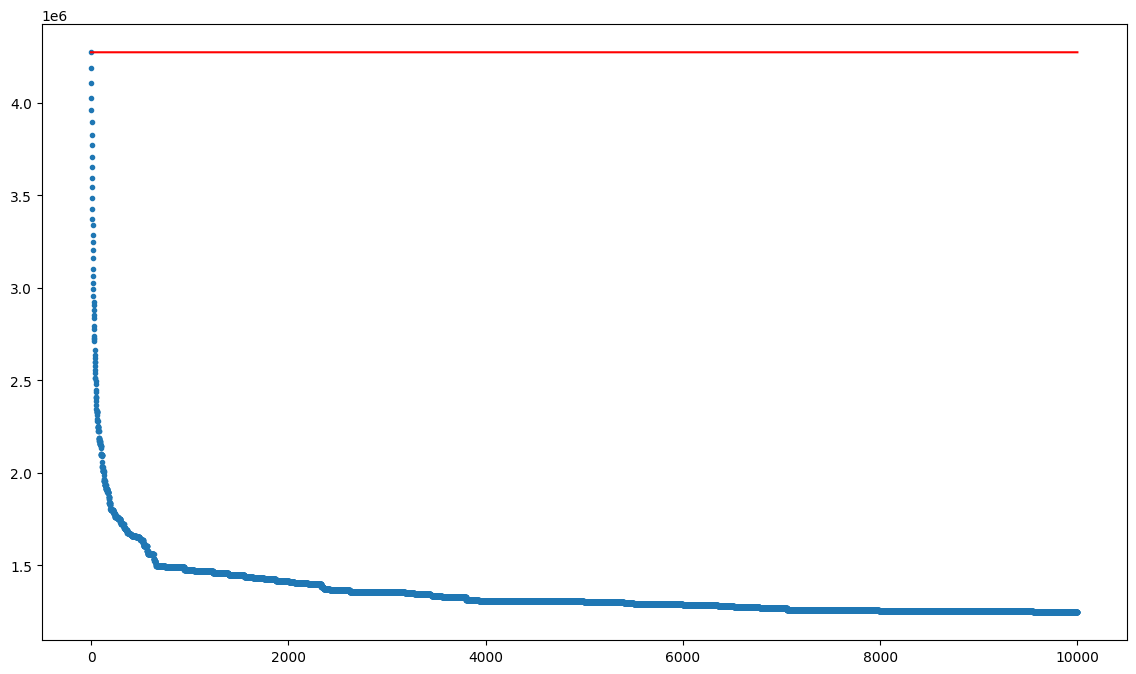

In [104]:
current_solution = solution
history = [cost(current_solution)]

steps =  0
for n in range(MAX_STEPS):
    
    steps += 1
    #tweak
  
    new_solution = tweak(current_solution)   

    if(valid(new_solution) and cost(new_solution) < cost(current_solution)):
        ic(steps, cost(current_solution), cost(new_solution))
        current_solution = new_solution
    history.append(cost(current_solution))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, min)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


valid(current_solution), cost(current_solution)